In [1]:
import sys
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos
from torch.utils.data import DataLoader
from func import OR,heatplot,misorientation,mat2plot, match,imgshow,calpoint,L2,L1,ipfread
from Class import Exp,Data,Cluster
import torch.nn.functional as F
import matplotlib.patches as patches

class Dataset(torch.utils.data.Dataset):
    def __init__(self,bef,im,target):
        self.bef=bef
        self.im=im
        self.target=target
    def __getitem__(self,index):
        X=self.bef[index]
        Y=self.target[index]
        im=self.im[index]
        return torch.tensor(X,dtype=torch.float32),torch.tensor(Y,dtype=torch.long),im
    def __len__(self):
        return len(self.bef)
def negsample(corner):
    mat=np.zeros([500,500])
    for (i,j) in corner:
        for k in range(max(0,i-49),min(500,i+50)):
            for l in range(max(0,j-49),min(500,j+50)):
                mat[k,l]=1
    cand = []
    for i in range(451):
        for j in range(451):
            if not mat[i][j]:
                cand.append([i,j])
    return random.sample(cand,len(corner))


In [3]:
def create_dataset(root="data/train/",feature=["orient","MAD"]):
    corner=torch.load("data/corner.pkl")
    bef=[]
    im=[]
    target=[]
    h=w=50
    for date in os.listdir(root):
        path=root+date+"/before/"
        data=Data(path)
        data.data["orient"]=data.data["orient"].reshape(data.h,data.w,-1)
        for (i,j) in corner[date]:
            im.append(ipfread(path)[i:i+h,j:j+w]/255.)
            app=[]
            for ele in feature:
                if ele=="orient":
                    app.append(data.data[ele][i:i+h,j:j+w])
                else:
                    app.append(data.data[ele][i:i+h,j:j+w,np.newaxis])
            bef.append(np.concatenate(app,axis=2))
            target.append(0)
        for (i,j) in negsample(corner[date]):
            im.append(ipfread(path)[i:i+h,j:j+w]/255.)
            app=[]
            for ele in feature:
                if ele=="orient":
                    app.append(data.data[ele][i:i+h,j:j+w])
                else:
                    app.append(data.data[ele][i:i+h,j:j+w,np.newaxis])
            bef.append(np.concatenate(app,axis=2))
            target.append(1)
        
    bef=np.transpose(np.array(bef),(0,3,1,2))
    im=np.array(im)
    target=np.array(target)
    return Dataset(bef,im,target)
train=create_dataset("data/train/",feature=["Orient","BC","BS"])
test=create_dataset("data/test/",feature=["Orient","BC","BS"])

KeyError: 'orient'

In [ ]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.batchnorm = nn.BatchNorm2d(in_channel)
        self.relu = nn.ReLU() # activation
        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool2d(kernel_size=2) 
        self.cnn1 = nn.Conv2d(in_channels=in_channel, out_channels=12, kernel_size=3, stride=1, padding=0) 
        self.cnn2 = nn.Conv2d(in_channels=12, out_channels=18, kernel_size=3, stride=1, padding=1) 
        self.cnn3 = nn.Conv2d(in_channels=18, out_channels=24, kernel_size=3, stride=1, padding=0) 
        self.fc1 = nn.Linear(24 * 5 * 5, 2) 
        self.softmax = nn.Softmax(1)
    def forward(self, x):
        # Convolution 1 50
        out = self.batchnorm(x)
        out = self.cnn1(x) # 48
        out = self.relu(out)
        out = self.maxpool(out) #24
        out = self.cnn2(out) #24
        out = self.relu(out) 
        out = self.maxpool(out) #12
        out = self.dropout(out)
        out = self.cnn3(out) #10
        out = self.relu(out)
        out = self.maxpool(out) #5
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        out = self.softmax(out)
        return out
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        self.batchnorm = nn.BatchNorm2d(in_channel)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU() # activation
        self.maxpool = nn.MaxPool2d(kernel_size=2) 
        self.cnn1 = nn.Conv2d(in_channels=in_channel, out_channels=12, kernel_size=3, stride=1, padding=0) 
        self.cnn2 = nn.Conv2d(in_channels=12, out_channels=18, kernel_size=3, stride=1, padding=0) 
        self.cnn3 = nn.Conv2d(in_channels=18, out_channels=24, kernel_size=3, stride=1, padding=0) 
        self.fc1 = nn.Linear(24 * 9 * 9, 2) 
        self.softmax = nn.Softmax(1)
    def forward(self, x):
        # Convolution 1 50
        out = self.batchnorm(x)
        out = self.cnn1(x) # 48
        out = self.relu(out)
        out = self.maxpool(out) #24
        out = self.cnn2(out) #22
        out = self.relu(out) 
        out = self.maxpool(out) #11
        out = self.dropout(out)
        out = self.cnn3(out) #9
        out = self.relu(out)
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        out = self.softmax(out)
        return out

In [ ]:
train_loader= DataLoader(train, batch_size=64, shuffle=True,  num_workers=0, drop_last=True )
test_loader= DataLoader(test, batch_size=64, shuffle=True,  num_workers=0,  drop_last=False )

In [28]:
torch.save(model,"model/CNN5_obcbs_0.804.pkl")

In [5]:
m1 = torch.load("model/CNN5_obcbs_0.804")
# m2 = torch.load("model/CNN3_obcbs_0.775")
# m3 = torch.load("model/CNN3_obcbs_0.775")
m1.eval()
# m2.eval()
cum=0
for batch_ndx, sample in enumerate(test_loader):
    X,Y,_= sample
    output=m1(X)
    predict = torch.max(output, 1)[1]
    cum+=np.sum((Y == predict).cpu().numpy())
print(cum/len(test))

0.7450980392156863


tensor(1)
tensor([[0.2701, 0.7299]], grad_fn=<SoftmaxBackward>)


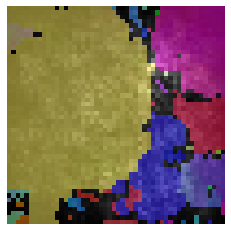

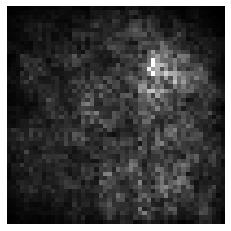

True

In [52]:
model = torch.load("model/CNN5_obcbs_0.804.pkl")
corner=torch.load("data/corner.pkl")
for param in model.parameters():
    param.requires_grad = False
index=98
X=test[index][0].unsqueeze(0)
print(test[index][1])
model.eval()
X.requires_grad_()
scores = model(X)
print(scores)
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]
score_max.backward()
saliency, _ = torch.max(X.grad.data.abs(),dim=1)
img=255*test[index][2][:,:,6:]
plt.imshow(img[...,[2,1,0]].astype("int"))
plt.axis('off')
plt.imshow(saliency[0],cmap="gray",alpha=0.5)
plt.savefig("output/test%d_cover.png"%(index),dpi=600,bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(saliency[0],cmap="gray")
plt.axis('off')
plt.savefig("output/test%d_sal.png"%(index),dpi=600,bbox_inches='tight', pad_inches=0)
plt.show()
cv2.imwrite("output/test%d_%d.png"%(index,test[index][1]),(255*test[index][2][:,:,6:]).astype("int"))
